In [1]:
# Imports
import re
import nltk
from nltk.tokenize import word_tokenize
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import lil_matrix, csr_matrix
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# For inline plots
%matplotlib inline

# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to /home/camelot/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/camelot/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Load the text file
filename = "text8.txt"
with open(filename, "r", encoding="utf-8") as f:
    text = f.read()

# Clean text
def clean_text(txt):
    txt = txt.lower() # Lowercase
    txt = re.sub(r'[^\x00-\x7F]+', ' ', txt)  # Remove non-ASCII characters
    txt = re.sub(r'\d+', '', txt)            # Remove digits
    txt = re.sub(r'[^\w\s]', '', txt)        # Remove punctuation
    return txt

text = clean_text(text)
print(f"Text after cleaning (sample): {text[:200]}")


Text after cleaning (sample):  anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term 


In [3]:
# Tokenize text
tokens = word_tokenize(text)

# Remove stopwords
stop_words = set(nltk.corpus.stopwords.words('english'))
tokens = [t for t in tokens if t not in stop_words and t.strip() != ""]
print(f"Number of tokens after cleaning and stopword removal: {len(tokens)}")


Number of tokens after cleaning and stopword removal: 10888361


In [4]:
# Vocabulary Creation
# Count word frequencies
# freq = Counter(tokens)
# most_common = freq.most_common()

# # Limit vocabulary size
# vocab_size = 5000
# vocab_list = [w for w, _ in most_common[:vocab_size]]
# vocab = {word: idx for idx, word in enumerate(vocab_list)}

# Filter tokens based on vocabulary
# filtered_tokens = [t for t in tokens if t in vocab_list]

# Vocabulary Creation Using Unique Words
vocab = set(tokens)  # All unique words
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

# Convert vocabulary to a list
vocab_list = list(vocab)

# Create a mapping from word to index and vice versa
vocab_to_index = {word: idx for idx, word in enumerate(vocab_list)}
print(f"Sample vocabulary (first 10 words): {vocab_list[:10]}")

# Filter tokens based on vocabulary
filtered_tokens = [t for t in tokens if t in vocab]
print(f"Number of tokens after filtering based on vocabulary: {len(filtered_tokens)}")


Vocabulary size: 253697
Sample vocabulary (first 10 words): ['kesari', 'babruysk', 'longbottom', 'taipings', 'teignmouth', 'elwulf', 'unhealthful', 'marcondes', 'rimas', 'gilan']
Number of tokens after filtering based on vocabulary: 10888361


In [5]:
# Co-occurrence Matrix Construction
# Initialize sparse co-occurrence matrix
window_size = 2
co_matrix_sparse = lil_matrix((vocab_size, vocab_size), dtype=int)

# Build co-occurrence matrix
for i, word in enumerate(filtered_tokens):
    for j in range(max(0, i - window_size), min(len(filtered_tokens), i + window_size + 1)):
        if i != j:
            co_matrix_sparse[vocab_to_index[word], vocab_to_index[filtered_tokens[j]]] += 1

# Convert to CSR format for efficient computation
co_matrix_sparse = csr_matrix(co_matrix_sparse)

# Check matrix properties
print(f"Co-occurrence matrix shape: {co_matrix_sparse.shape}")
print(f"Non-zero elements in the matrix: {co_matrix_sparse.nnz}")


Co-occurrence matrix shape: (253697, 253697)
Non-zero elements in the matrix: 18728806


In [6]:
# Normalize and reduce dimensions
co_matrix_normalized = normalize(co_matrix_sparse, norm='l2', axis=1)
svd = TruncatedSVD(n_components=10, random_state=42)
reduced_matrix = svd.fit_transform(co_matrix_normalized)


In [7]:
from sklearn.model_selection import KFold
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Set parameters for cross-validation
max_k = 20  # Maximum number of clusters
n_folds = 5  # Number of folds for cross-validation

kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
k_values = range(2, max_k + 1)

# Initialize lists to store average scores for each metric
avg_silhouette_scores = []
avg_ch_scores = []
avg_db_scores = []
inertia_scores = []


In [8]:
for k in k_values:
    silhouette_scores = []
    ch_scores = []
    db_scores = []

    print(f"Evaluating K={k}")
    
    for train_idx, val_idx in kf.split(reduced_matrix):
        # Split the data into training and validation sets
        train_data = reduced_matrix[train_idx]
        val_data = reduced_matrix[val_idx]

        # Train K-Means on the training data
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(train_data)

        # Predict clusters on the validation data
        val_labels = kmeans.predict(val_data)

        # Metrics on the validation data
        silhouette_scores.append(silhouette_score(val_data, val_labels))
        ch_scores.append(calinski_harabasz_score(val_data, val_labels))
        db_scores.append(davies_bouldin_score(val_data, val_labels))

    # Calculate inertia for the full dataset
    kmeans_full = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_full.fit(reduced_matrix)
    inertia_scores.append(kmeans_full.inertia_)

    # Compute average scores for this K
    avg_silhouette_scores.append(np.mean(silhouette_scores))
    avg_ch_scores.append(np.mean(ch_scores))
    avg_db_scores.append(np.mean(db_scores))

    print(f"K={k}: Avg Silhouette={np.mean(silhouette_scores):.4f}, "
          f"Avg CH={np.mean(ch_scores):.4f}, Avg DB={np.mean(db_scores):.4f}, "
          f"Inertia={kmeans_full.inertia_:.2f}")


Evaluating K=2
K=2: Avg Silhouette=0.5363, Avg CH=18279.8765, Avg DB=1.2267, Inertia=14341.03
Evaluating K=3
K=3: Avg Silhouette=0.5495, Avg CH=13360.7067, Avg DB=1.6148, Inertia=12778.07
Evaluating K=4
K=4: Avg Silhouette=0.5398, Avg CH=10969.2416, Avg DB=1.4182, Inertia=11838.69
Evaluating K=5
K=5: Avg Silhouette=0.5508, Avg CH=9915.0845, Avg DB=1.3900, Inertia=10918.96
Evaluating K=6
K=6: Avg Silhouette=0.5229, Avg CH=9411.6988, Avg DB=1.4279, Inertia=10113.56
Evaluating K=7
K=7: Avg Silhouette=0.5199, Avg CH=9068.2822, Avg DB=1.3818, Inertia=9432.61
Evaluating K=8
K=8: Avg Silhouette=0.5265, Avg CH=8977.5777, Avg DB=1.4404, Inertia=8751.97
Evaluating K=9
K=9: Avg Silhouette=0.5034, Avg CH=8837.7674, Avg DB=1.3323, Inertia=8217.30
Evaluating K=10
K=10: Avg Silhouette=0.5232, Avg CH=8811.6903, Avg DB=1.3888, Inertia=7616.50
Evaluating K=11
K=11: Avg Silhouette=0.5306, Avg CH=8743.4133, Avg DB=1.2817, Inertia=7256.40
Evaluating K=12
K=12: Avg Silhouette=0.5356, Avg CH=8669.8906, Avg D

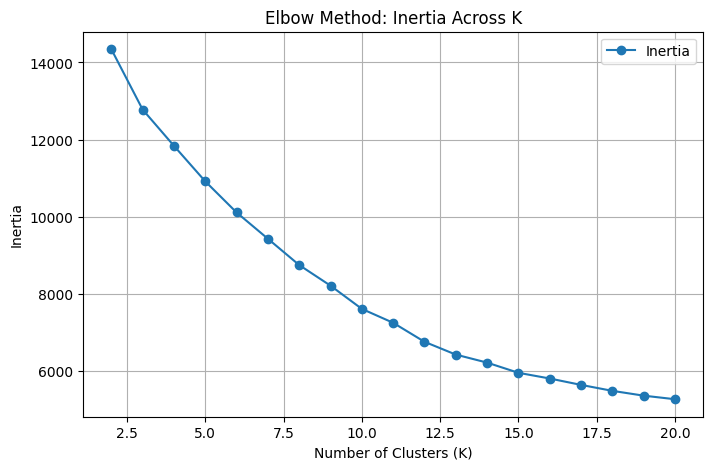

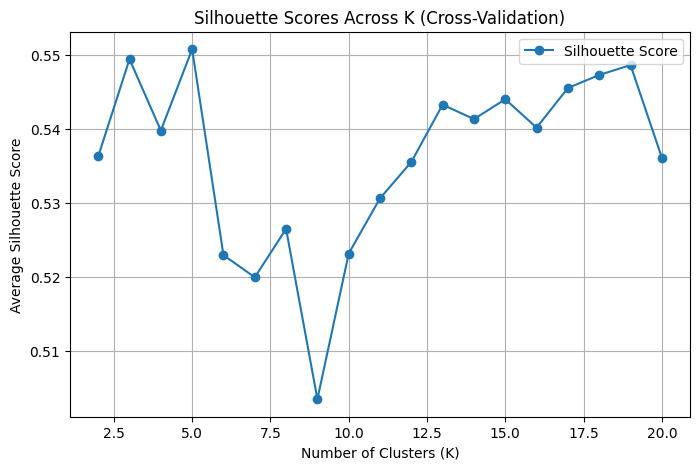

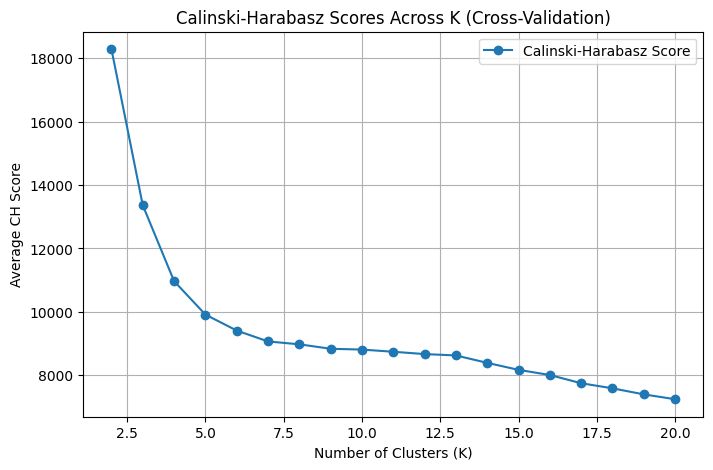

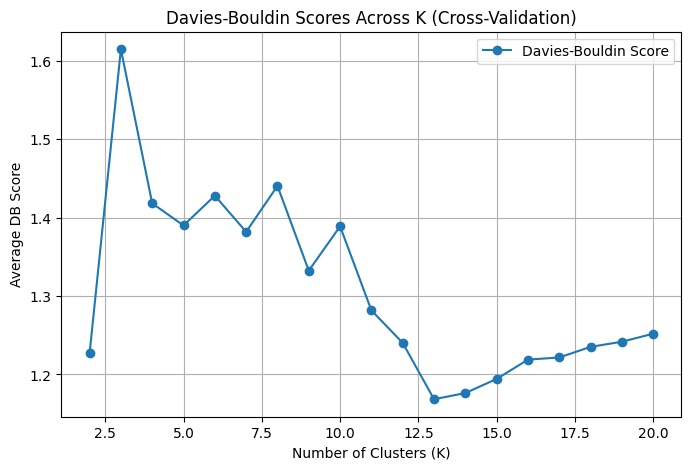

In [9]:
# Plot Inertia (Elbow Method)
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia_scores, marker='o', label="Inertia")
plt.title("Elbow Method: Inertia Across K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.grid()
plt.legend()
plt.show()

# Plot Silhouette Scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, avg_silhouette_scores, marker='o', label="Silhouette Score")
plt.title("Silhouette Scores Across K (Cross-Validation)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Average Silhouette Score")
plt.grid()
plt.legend()
plt.show()

# Plot Calinski-Harabasz Scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, avg_ch_scores, marker='o', label="Calinski-Harabasz Score")
plt.title("Calinski-Harabasz Scores Across K (Cross-Validation)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Average CH Score")
plt.grid()
plt.legend()
plt.show()

# Plot Davies-Bouldin Scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, avg_db_scores, marker='o', label="Davies-Bouldin Score")
plt.title("Davies-Bouldin Scores Across K (Cross-Validation)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Average DB Score")
plt.grid()
plt.legend()
plt.show()


In [10]:
train_labels = kmeans.labels_
train_silhouette = silhouette_score(train_data, train_labels)
train_ch_score = calinski_harabasz_score(train_data, train_labels)
train_db_score = davies_bouldin_score(train_data, train_labels)

print(f"Training Metrics for K={k}: "
      f"Silhouette={train_silhouette:.4f}, "
      f"CH={train_ch_score:.4f}, "
      f"DB={train_db_score:.4f}")


Training Metrics for K=20: Silhouette=0.5516, CH=29053.0687, DB=1.2567


In [11]:
from sklearn.decomposition import PCA

# Reduce to 2D for visualization
pca = PCA(n_components=2, random_state=42)
reduced_2d = pca.fit_transform(reduced_matrix)

# Fit K-Means with the optimal K
optimal_k = 5  # Adjust as needed
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans.fit(reduced_matrix)
cluster_labels = kmeans.labels_


In [12]:
# Reverse map from index to word
index_to_word = {idx: word for word, idx in vocab_to_index.items()}

# Assign each word to a cluster
word_cluster_map = {}
for word, idx in vocab_to_index.items():
    cluster_id = kmeans.predict(reduced_matrix[idx].reshape(1, -1))[0]
    word_cluster_map[word] = cluster_id

# Analyze most frequent words in each cluster
from collections import defaultdict

cluster_words = defaultdict(list)
for word, cluster_id in word_cluster_map.items():
    cluster_words[cluster_id].append(word)

# Print top words in each cluster
for cluster_id, words in cluster_words.items():
    print(f"Cluster {cluster_id}: {', '.join(words[:10])}")  # Show top 10 words per cluster


Cluster 4: kesari, ezell, sigisbert, thinkin, ahoy, gorsky, cityhallpostalcode, rodwell, chaconne, diamant
Cluster 0: babruysk, longbottom, taipings, teignmouth, elwulf, unhealthful, marcondes, rimas, gilan, militran
Cluster 2: smuggles, graphemes, hum, nauen, menneske, huloet, conried, mohafazah, panpra, aritomo
Cluster 1: dba, samul, dragstrip, finder, vatatzes, queensberry, councillors, gleanings, peraluminous, deiotarus
Cluster 3: dafif, verifed, traboulsi, ostrow, lvresource, noninterlaced, fanning, okrent, pbk, unvariolatedc


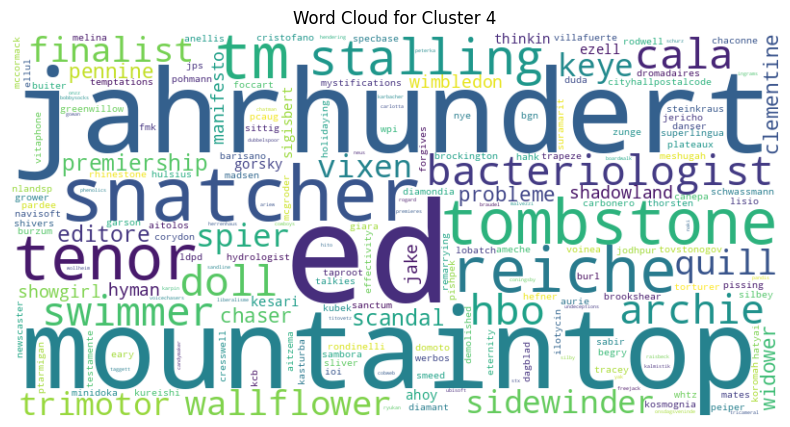

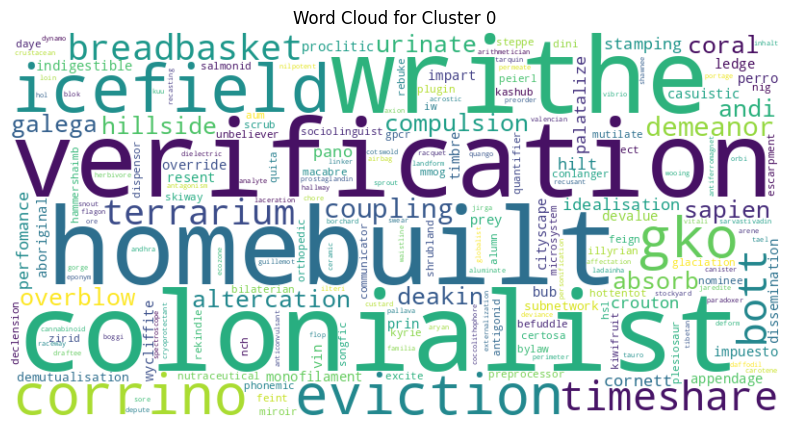

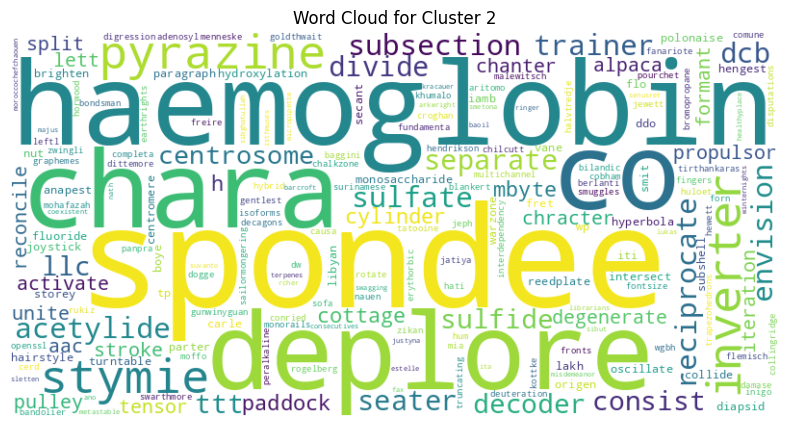

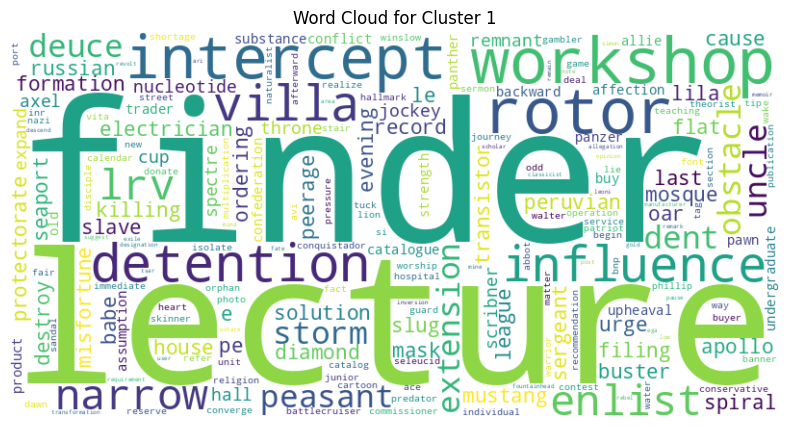

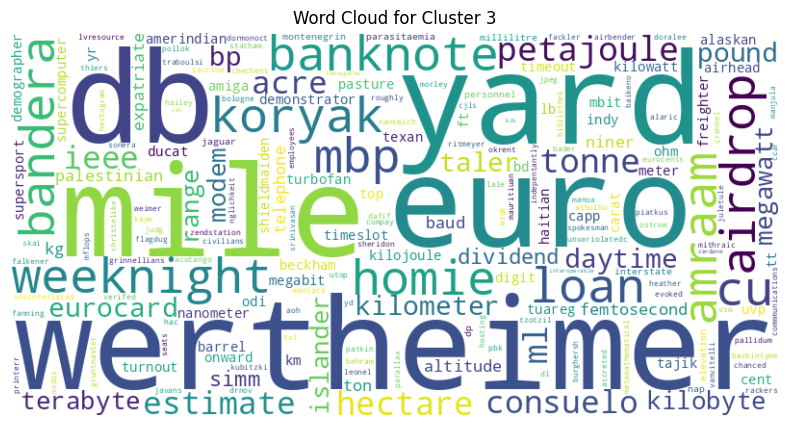

In [13]:
from wordcloud import WordCloud

# Generate word clouds for each cluster
for cluster_id, words in cluster_words.items():
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(words))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud for Cluster {cluster_id}")
    plt.show()
